# Demonstrate examples for collaboration with novo nordisk

In [ ]:
import sys, os

# add the project root to sys.path
root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if root not in sys.path:
    sys.path.insert(0, root)

from data_causl.utils import *
from data_causl.data import *
from frengression import *

device = torch.device('cpu')
from CausalEGM import *

import numpy as np
import pickle
import os
from tqdm import tqdm
import src.exp_utils as exp_utils
import torch.nn as nn
import torch.distributions as dist


from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import log_loss
from scipy.spatial.distance import pdist, squareform
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

from engression.models import StoNet, StoNetBase
class SpecifiedCausalMargin(StoNetBase):
    def __init__(self, ate, noise_dim, eta_dist, x_dim):
        super().__init__(noise_dim=noise_dim)
        self.ate = ate  # or self.register_buffer('eta', torch.tensor(eta))
        self.x_dim = x_dim
        self.eta_dist = eta_dist

    def forward(self, x):
        if x.shape[1]==self.x_dim:
            if self.eta_dist == 'gamma':
                # per‐element alpha, beta
                alpha_arr = torch.full(x.shape, 2.0, device=x.device)
                beta_arr  = torch.full(x.shape, 1.0, device=x.device)
                gamma_dist = torch.distributions.Gamma(alpha_arr, beta_arr)
                eta = gamma_dist.sample()
            if self.eta_dist == 'gaussian':
                eta = torch.randn(x.shape, device=x.device)
        else:
            x_eta = x.clone()
            x = x_eta[:, :self.x_dim]
            eta_inp = x_eta[:, self.x_dim:]
            if self.eta_dist== 'gaussian':
                eta = eta_inp  
            if self.eta_dist == 'gamma':
                alpha = torch.full_like(eta_inp, 2.0)
                beta  = torch.full_like(eta_inp, 1.0)
                gamma = dist.Gamma(alpha, beta)
                u = dist.Normal(0, 1).cdf(eta_inp)
                eta = gamma.icdf(u)
        # other distributions can be implemented likewise
        return self.ate * x + eta

# Helper function for MMD
def mmd_rbf(x, y, sigma=1.0):
    """Compute MMD between two distributions using RBF kernel."""
    pairwise_sq_dists = squareform(pdist(np.vstack([x, y]), 'sqeuclidean'))
    K = np.exp(-pairwise_sq_dists / (2 * sigma ** 2))
    K_xx = K[:len(x), :len(x)]
    K_xy = K[:len(x), len(x):]
    K_yy = K[len(x):, len(x):]
    mmd = np.mean(K_xx) - 2 * np.mean(K_xy) + np.mean(K_yy)
    return mmd


np.random.seed(42)

# nI = 3
# nX = 2
# nO = 2
# nS= 2
# p = nI+nX+nO+nS
# ate = 4
# beta_cov = 0
# strength_instr = 0
# strength_conf = 0
# strength_outcome = 1
# binary_intervention=True
nI = 2
nX = 0
nO = 2
nS= 2
p = nI+nX+nO+nS
ate = 2
beta_cov = 0
strength_instr = 0
strength_conf = 0
strength_outcome = 1
binary_intervention=True

In [9]:
df_tr = generate_data_causl(n=6000, nI =nI, nX= nX, nO = nO, nS = nS, ate = ate, beta_cov = beta_cov, strength_instr = strength_instr, strength_conf = strength_conf, strength_outcome =strength_outcome, binary_intervention=binary_intervention)
z_tr = torch.tensor(df_tr[[f"X{i}" for i in range(1, p + 1)]].values, dtype=torch.float32)
x_tr = torch.tensor(df_tr['A'].values, dtype=torch.int32).view(-1, 1)
y_tr = torch.tensor(df_tr['y'].values, dtype=torch.float32).view(-1, 1)

# Original frengression

In [11]:
model = Frengression(x_tr.shape[1], y_tr.shape[1], z_tr.shape[1], noise_dim=1, num_layer=3, hidden_dim=100, device=device, x_binary = binary_intervention)
model.train_xz(x_tr, z_tr, num_iters=2000, lr=1e-4, print_every_iter=1000)
model.train_y(x_tr, z_tr, y_tr, num_iters=3000, lr=1e-4, print_every_iter=1000,tol=0.000)

Epoch 1: loss 2.3130, loss1 2.4286, loss2 0.2312
Epoch 1000: loss 1.7111, loss1 3.4072, loss2 3.3921
Epoch 2000: loss 1.6999, loss1 3.4009, loss2 3.4020
Epoch 1: loss 2.1899,	loss_y 1.4113, 1.4377, 0.0528,	loss_eta 0.7786, 0.8108, 0.0645
Epoch 1000: loss 0.9942,	loss_y 0.4362, 0.8710, 0.8697,	loss_eta 0.5581, 1.1209, 1.1257
Epoch 2000: loss 1.0006,	loss_y 0.4309, 0.8688, 0.8757,	loss_eta 0.5697, 1.1187, 1.0980
Epoch 3000: loss 0.9929,	loss_y 0.4362, 0.8712, 0.8700,	loss_eta 0.5567, 1.1229, 1.1323


In [25]:
# torch.save(model,"result/model_distributional.pt")
model = torch.load("result/model_distributional.pt")

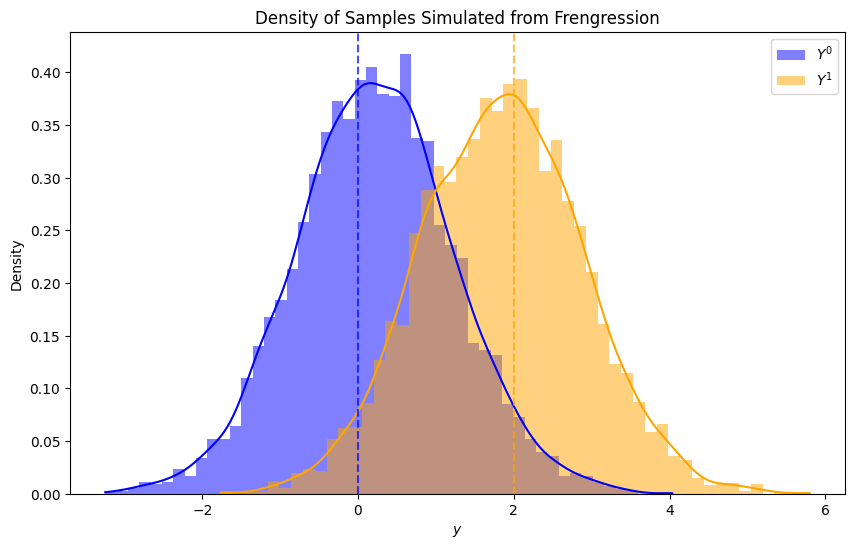

In [12]:
# Sample causal margins
x0_samples = model.sample_causal_margin(x=torch.tensor([[0]], dtype=torch.int32), sample_size=5000).numpy().flatten()
x1_samples = model.sample_causal_margin(x=torch.tensor([[1]], dtype=torch.int32), sample_size=5000).numpy().flatten()
sampled_x,sampled_y,sampled_z = model.sample_joint(sample_size=5000)
# Plot histograms and KDE
plt.figure(figsize=(10, 6))

# Histogram for x0_samples
sns.histplot(x0_samples, kde=True, color='blue', label='$Y^0$', stat="density", bins=50, edgecolor=None, alpha=0.5)

# Histogram for x1_samples
sns.histplot(x1_samples, kde=True, color='orange', label='$Y^1$', stat="density", bins=50, edgecolor=None, alpha=0.5)

# Highlight different supports (if needed)
# plt.axvline(min(x0_samples), color='blue', linestyle='--', alpha=0.7, label='$Y^0$ suppor end')
plt.axvline(x=0, color='blue', linestyle='--', alpha=0.7)
# plt.axvline(min(x1_samples), color='orange', linestyle='--', alpha=0.7, label='$Y^1$ support end')
plt.axvline(x=2, color='orange', linestyle='--', alpha=0.7)

# Add labels, legend, and title
plt.xlabel("$y$")
plt.ylabel("Density")
plt.title("Density of Samples Simulated from Frengression")
plt.legend()
plt.show()


In [13]:
margin_module = SpecifiedCausalMargin(ate=5, eta_dist="gaussian", x_dim=model.x_dim, noise_dim=model.noise_dim)
model.specify_causal(causal_margin=margin_module)


sampled_x_5x,sampled_y_5x,sampled_z_5x = model.sample_joint(sample_size=5000)
print('Diff-in-means: ', sampled_y_5x[sampled_x_5x==1].mean()-sampled_y_5x[sampled_x_5x==0].mean())
print('Proportion of sampled treated: ', (sampled_x_5x==1).sum()/sampled_x_5x.shape[0])
print('Proportion of true treated: ', (x_tr==1).sum()/x_tr.shape[0])

Diff-in-means:  tensor(4.9565)
Proportion of sampled treated:  tensor(0.6184)
Proportion of true treated:  tensor(0.5138)


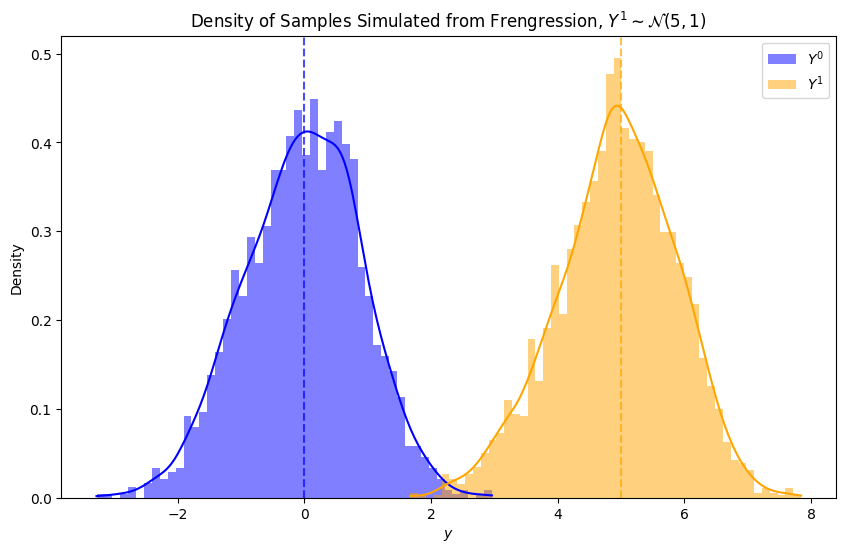

In [14]:
# Plot histograms and KDE
plt.figure(figsize=(10, 6))

# Histogram for x0_samples
sns.histplot(sampled_y_5x[sampled_x_5x==0], kde=True, color='blue', label='$Y^0$', stat="density", bins=50, edgecolor=None, alpha=0.5)

# Histogram for x1_samples
sns.histplot(sampled_y_5x[sampled_x_5x==1], kde=True, color='orange', label='$Y^1$', stat="density", bins=50, edgecolor=None, alpha=0.5)

# Highlight different supports (if needed)
# plt.axvline(min(x0_samples), color='blue', linestyle='--', alpha=0.7, label='$Y^0$ suppor end')
plt.axvline(x=0, color='blue', linestyle='--', alpha=0.7)
# plt.axvline(min(x1_samples), color='orange', linestyle='--', alpha=0.7, label='$Y^1$ support end')
plt.axvline(x=5, color='orange', linestyle='--', alpha=0.7)

# Add labels, legend, and title
plt.xlabel("$y$")
plt.ylabel("Density")
plt.title(R"Density of Samples Simulated from Frengression, $Y^1\sim\mathcal{N}(5,1)$")
plt.legend()
plt.show()


In [37]:
class SpecifiedCausalMargin(StoNetBase):
    def __init__(self, ate, noise_dim, eta_dist, x_dim):
        super().__init__(noise_dim=noise_dim)
        self.ate = ate  # or self.register_buffer('eta', torch.tensor(eta))
        self.x_dim = x_dim
        self.eta_dist = eta_dist

    def forward(self, x):
        if x.shape[1]==self.x_dim:

            if self.eta_dist == 'gamma':
                # per‐element alpha, beta
                alpha_arr = torch.full(x.shape, 2.0, device=x.device)
                beta_arr  = torch.full(x.shape, 1.0, device=x.device)
                gamma_dist = torch.distributions.Gamma(alpha_arr, beta_arr)
                eta = gamma_dist.sample()
            if self.eta_dist == 'gaussian':
                eta = torch.randn(x.shape, device=x.device)
        else:
            x_eta = torch.clone(x)
            x = x_eta[:, :self.x_dim]
            eta = x_eta[:, self.x_dim:]            
        # other distributions can be implemented likewise
        return self.ate * x + eta

In [38]:
margin_module = SpecifiedCausalMargin(ate=0, noise_dim=model.noise_dim, eta_dist = 'gaussian',x_dim = x_tr.shape[1])
model.specify_causal(causal_margin=margin_module)
# model.train_y(x_tr, z_tr, y_tr, num_iters=100000, lr=1e-4, print_every_iter=1000)
sampled_x_0x,sampled_y_0x,sampled_z_0x = model.sample_joint(sample_size=5000)
print('Diff-in-means: ', sampled_y_0x[sampled_x_0x==1].mean()-sampled_y_0x[sampled_x_0x==0].mean())
print('Proportion of sampled treated: ', (sampled_x_0x==1).sum()/sampled_x_0x.shape[0])
print('Proportion of true treated: ', (x_tr==1).sum()/x_tr.shape[0])

Diff-in-means:  tensor(0.0004)
Proportion of sampled treated:  tensor(0.6304)
Proportion of true treated:  tensor(0.5138)


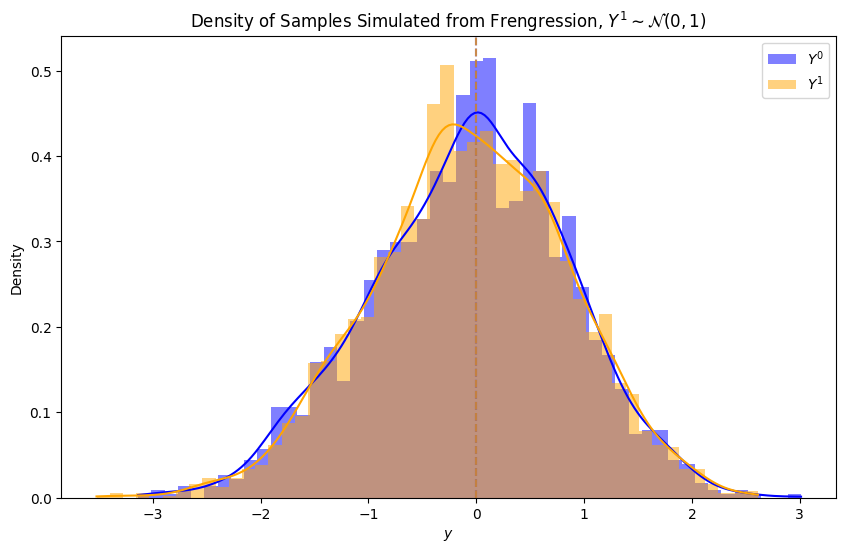

In [39]:
# Plot histograms and KDE
plt.figure(figsize=(10, 6))

# Histogram for x0_samples
sns.histplot(sampled_y_0x[sampled_x_0x==0], kde=True, color='blue', label='$Y^0$', stat="density", bins=50, edgecolor=None, alpha=0.5)

# Histogram for x1_samples
sns.histplot(sampled_y_0x[sampled_x_0x==1], kde=True, color='orange', label='$Y^1$', stat="density", bins=50, edgecolor=None, alpha=0.5)

# Highlight different supports (if needed)
# plt.axvline(min(x0_samples), color='blue', linestyle='--', alpha=0.7, label='$Y^0$ suppor end')
plt.axvline(x=0, color='blue', linestyle='--', alpha=0.7)
# plt.axvline(min(x1_samples), color='orange', linestyle='--', alpha=0.7, label='$Y^1$ support end')
plt.axvline(x=0, color='orange', linestyle='--', alpha=0.7)

# Add labels, legend, and title
plt.xlabel("$y$")
plt.ylabel("Density")
plt.title(R"Density of Samples Simulated from Frengression, $Y^1\sim\mathcal{N}(0,1)$")
plt.legend()
plt.show()


In [80]:
import torch.distributions as dist
import torch.special as special
class SpecifiedCausalMargin(StoNetBase):
    def __init__(self, ate, noise_dim, eta_dist, x_dim):
        super().__init__(noise_dim=noise_dim)
        self.ate = ate  # or self.register_buffer('eta', torch.tensor(eta))
        self.x_dim = x_dim
        self.eta_dist = eta_dist

    def forward(self, x):
        if x.shape[1]==self.x_dim:
            if self.eta_dist == 'gamma':
                # per‐element alpha, beta
                alpha_arr = torch.full(x.shape, 2.0, device=x.device)
                beta_arr  = torch.full(x.shape, 1.0, device=x.device)
                gamma_dist = torch.distributions.Gamma(alpha_arr, beta_arr)
                eta = gamma_dist.sample()
            if self.eta_dist == 'gaussian':
                eta = torch.randn(x.shape, device=x.device)
            if self.eta_dist == 'laplace':
                lap  = dist.Laplace(0, 0.5)
                eta  = lap.sample(x.shape,device=x.device)
            if self.eta_dist == 'lognormal':
                lognorm = dist.LogNormal(0, 1)
                eta     = lognorm.sample(x.shape).to(x.device)
        else:
            x_eta = x.clone()
            x = x_eta[:, :self.x_dim]
            eta_inp = x_eta[:, self.x_dim:]
            if self.eta_dist== 'gaussian':
                eta = eta_inp  
            if self.eta_dist == 'gamma':
                alpha = torch.full_like(eta_inp, 2.0)
                beta  = torch.full_like(eta_inp, 1.0)
                u = dist.Normal(0, 1).cdf(eta_inp)
                u = u.clamp(min=1e-6, max=1 - 1e-6)
                eta = special.gammaincinv(alpha, u) / beta
            if self.eta_dist == 'laplace':
                u = dist.Normal(0, 0.5).cdf(eta_inp)
                u = u.clamp(min=1e-6, max=1-1e-6)
                eta = torch.where(
                    u < 0.5,
                    0 +  0.5*torch.log(2 * u),
                    0 -  0.5* torch.log(2 * (1 - u))
                )
            # if self.eta_dist == 'lognormal':
            #     eta   = torch.exp(0 + 1 * eta_inp)

        # other distributions can be implemented likewise
        return self.ate * x + eta

In [81]:
margin_module = SpecifiedCausalMargin(ate=2, noise_dim=model.noise_dim, eta_dist = 'laplace',x_dim = x_tr.shape[1])
model.specify_causal(causal_margin=margin_module)
# model.train_y(x_tr, z_tr, y_tr, num_iters=100000, lr=1e-4, print_every_iter=1000)
sampled_x_2x,sampled_y_2x,sampled_z_2x = model.sample_joint(sample_size=10000)
print('Diff-in-means: ', sampled_y_2x[sampled_x_2x==1].mean()-sampled_y_2x[sampled_x_2x==0].mean())
print('Proportion of sampled treated: ', (sampled_x_2x==1).sum()/sampled_x_2x.shape[0])
print('Proportion of true treated: ', (x_tr==1).sum()/x_tr.shape[0])

Diff-in-means:  tensor(1.9889)
Proportion of sampled treated:  tensor(0.6290)
Proportion of true treated:  tensor(0.5138)


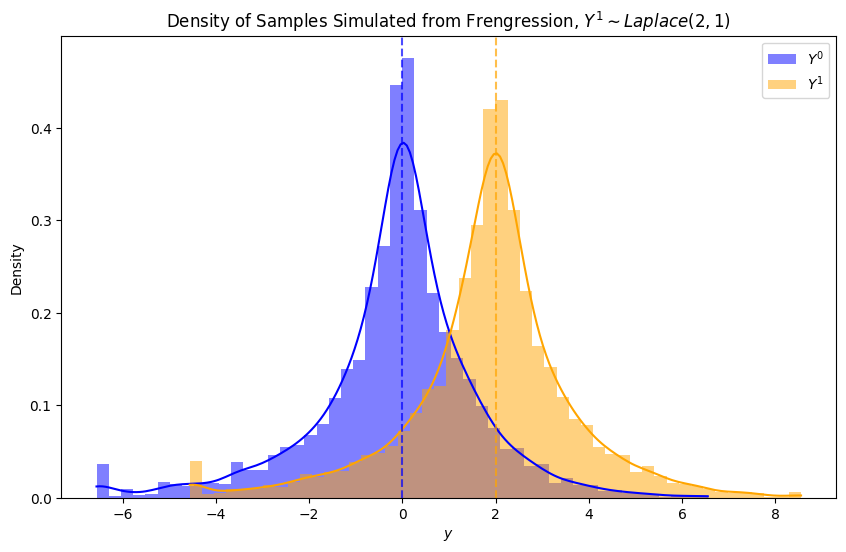

In [82]:
# Plot histograms and KDE
plt.figure(figsize=(10, 6))

# Histogram for x0_samples
sns.histplot(sampled_y_2x[sampled_x_2x==0], kde=True, color='blue', label='$Y^0$', stat="density", bins=50, edgecolor=None, alpha=0.5)

# Histogram for x1_samples
sns.histplot(sampled_y_2x[sampled_x_2x==1], kde=True, color='orange', label='$Y^1$', stat="density", bins=50, edgecolor=None, alpha=0.5)

# Highlight different supports (if needed)
# plt.axvline(min(x0_samples), color='blue', linestyle='--', alpha=0.7, label='$Y^0$ suppor end')
plt.axvline(x=0, color='blue', linestyle='--', alpha=0.7)
# plt.axvline(min(x1_samples), color='orange', linestyle='--', alpha=0.7, label='$Y^1$ support end')
plt.axvline(x=2, color='orange', linestyle='--', alpha=0.7)

# Add labels, legend, and title
plt.xlabel("$y$")
plt.ylabel("Density")
plt.title(R"Density of Samples Simulated from Frengression, $Y^1\sim Laplace(2,1)$")
plt.legend()
plt.show()


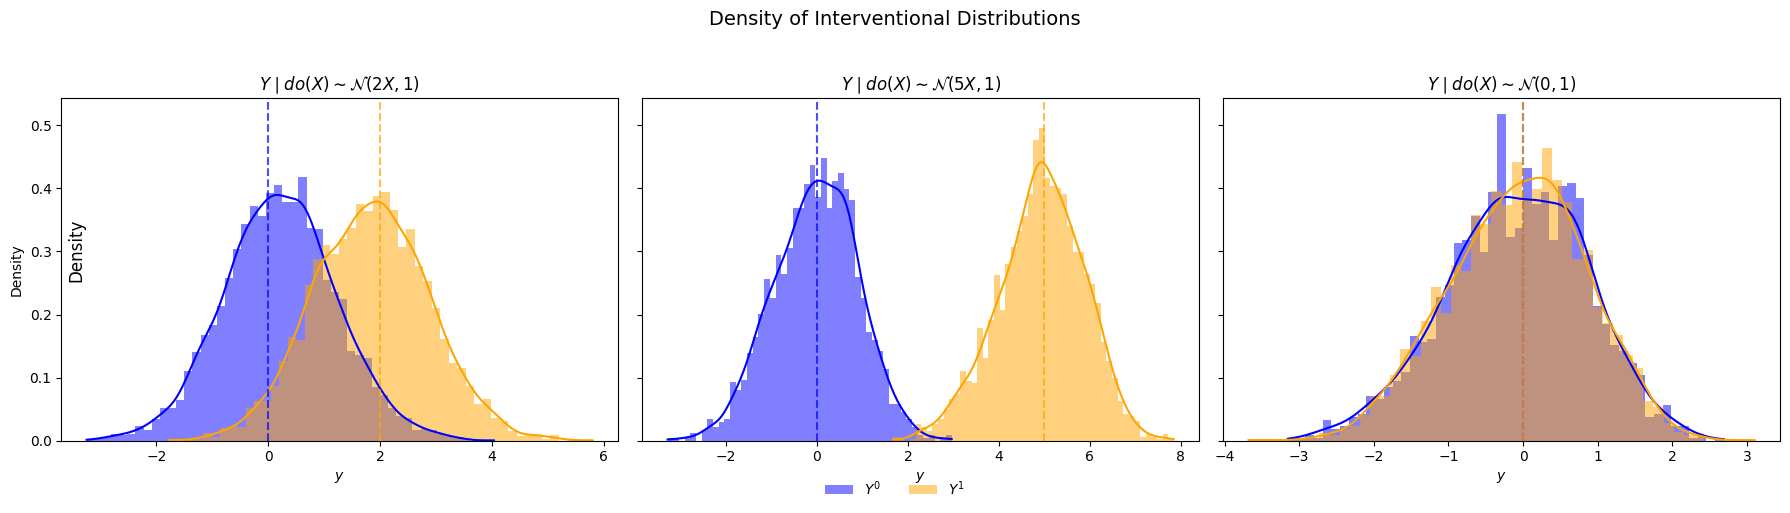

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# assume x0_samples, x1_samples, sampled_y_5x, sampled_x_5x, sampled_y_0x, sampled_x_0x
# are already in your namespace as from your code above

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# common styling
plot_args = dict(kde=True, stat="density", bins=50, edgecolor=None, alpha=0.5)

# 1) causal margins
sns.histplot(x0_samples, color='blue', label='$Y^0$', ax=axes[0], **plot_args)
sns.histplot(x1_samples, color='orange', label='$Y^1$', ax=axes[0], **plot_args)
axes[0].axvline(0, linestyle='--', color='blue', alpha=0.7)
axes[0].axvline(2, linestyle='--', color='orange', alpha=0.7)
axes[0].set_title("$Y\mid do(X)\sim\mathcal{N}(2X,1)$")
axes[0].set_xlabel("$y$")

# 2) joint sample with ATE=5
sns.histplot(sampled_y_5x[sampled_x_5x==0], color='blue', ax=axes[1], **plot_args)
sns.histplot(sampled_y_5x[sampled_x_5x==1], color='orange', ax=axes[1], **plot_args)
axes[1].axvline(0, linestyle='--', color='blue', alpha=0.7)
axes[1].axvline(5, linestyle='--', color='orange', alpha=0.7)
axes[1].set_title(r"$Y\mid do(X)\sim\mathcal{N}(5X,1)$")
axes[1].set_xlabel("$y$")

# 3) joint sample with ATE=0
sns.histplot(sampled_y_0x[sampled_x_0x==0], color='blue', ax=axes[2], **plot_args)
sns.histplot(sampled_y_0x[sampled_x_0x==1], color='orange', ax=axes[2], **plot_args)
axes[2].axvline(0, linestyle='--', color='blue', alpha=0.7)
axes[2].axvline(0, linestyle='--', color='orange', alpha=0.7)
axes[2].set_title(r"$Y\mid do(X)\sim\mathcal{N}(0,1)$")
axes[2].set_xlabel("$y$")

# share one y-label
fig.text(0.04, 0.5, 'Density', va='center', rotation='vertical', fontsize=12)
handles, labels = axes[0].get_legend_handles_labels()
# build a single legend (get handles from the first axis)
fig.legend(
    handles, labels,
    loc="lower center",
    ncol=len(handles),
    frameon=False,
    fontsize=10,
    bbox_to_anchor=(0.5, -0.02)
)

# fig.legend(handles, labels, loc='lower center', ncol=2, frameon=False, fontsize=12)
plt.suptitle(R"Density of Interventional Distributions", fontsize=14, y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space up top for the legend
plt.show()


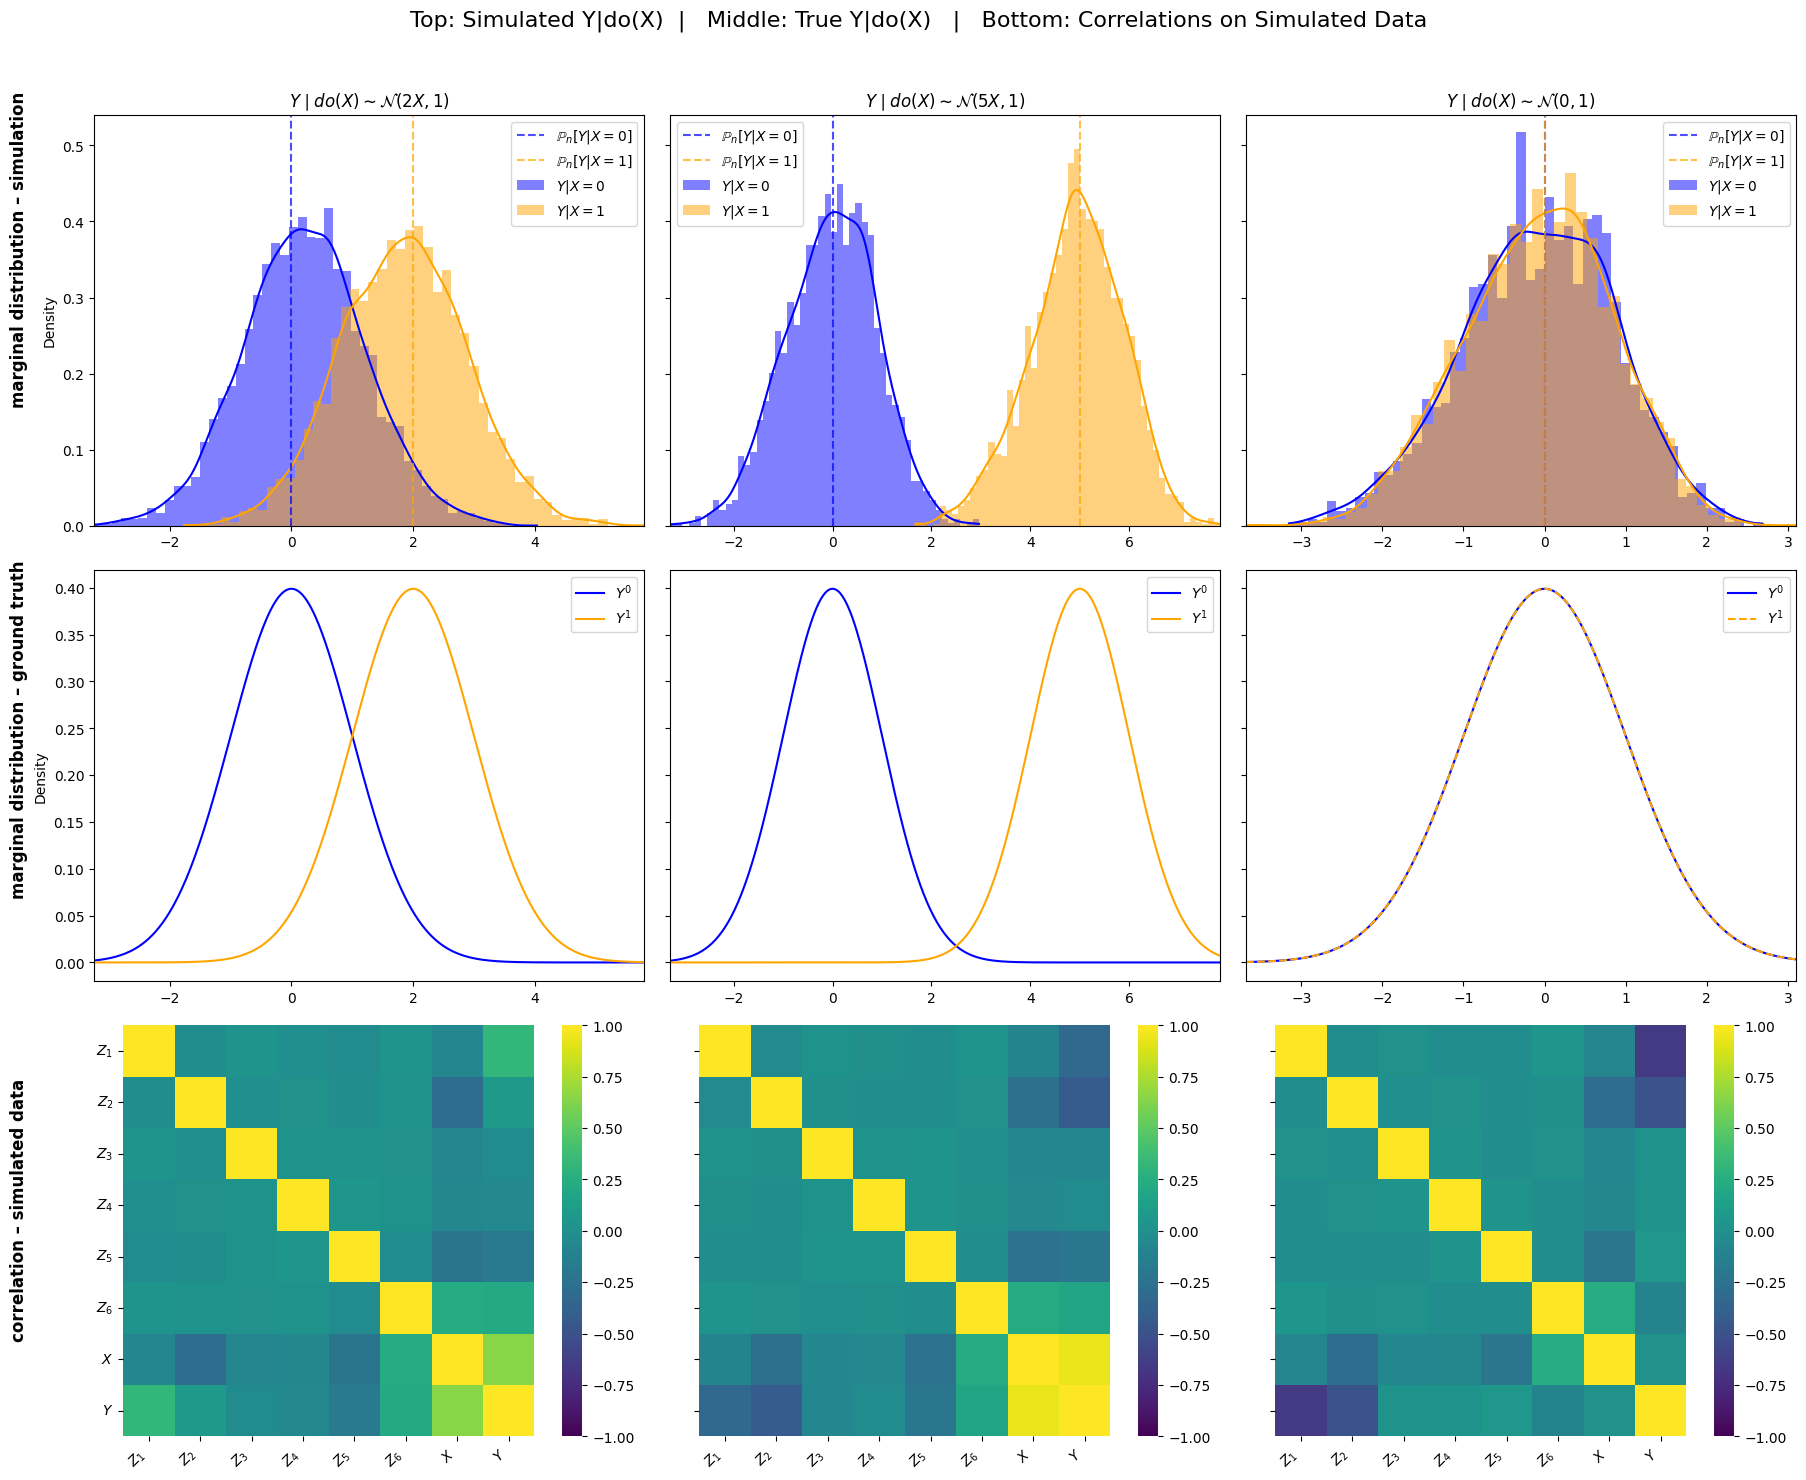

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

# — your data arrays must already be defined — 
# x0_samples, x1_samples               
# sampled_x_5x, sampled_y_5x           
# sampled_x_0x, sampled_y_0x           
# z0_samples, z1_samples               # shape (n_obs, p)
# sampled_z_5x, sampled_z_0x           # shape (n_obs, p)
# sampled_z, sampled_x, sampled_y      # combined marginals for col-0

fig, axes = plt.subplots(3, 3, figsize=(18, 15), sharey='row')

# 1) Rotated row titles
row_labels = [
    "marginal distribution – simulation",
    "marginal distribution – ground truth",
    "correlation – simulated data"
]
y_positions = [0.82, 0.50, 0.18]
for lab, y in zip(row_labels, y_positions):
    fig.text(
        x=0.0, y=y, s=lab,
        va='center', ha='center',
        rotation=90, fontsize=12, weight='bold'
    )

# 2) Compute per-column x-limits
y0 = np.concatenate([np.ravel(x0_samples), np.ravel(x1_samples)])
xmin0, xmax0 = y0.min(), y0.max()
y1 = np.ravel(sampled_y_5x); xmin1, xmax1 = y1.min(), y1.max()
y2 = np.ravel(sampled_y_0x); xmin2, xmax2 = y2.min(), y2.max()

# Common histogram + KDE styling
hist_args = dict(
    stat="density",
    bins=50,
    kde=True,           # ← fit & plot KDE
    edgecolor=None,
    alpha=0.5
)

### Row 1: simulated marginals ###
# Col 0: do(X)=0 vs do(X)=1
sns.histplot(x0_samples, color='blue', label='$Y|X=0$', ax=axes[0,0], **hist_args)
sns.histplot(x1_samples, color='orange', label='$Y|X=1$', ax=axes[0,0], **hist_args)
# dashed lines at the sample means
axes[0,0].axvline(0, linestyle='--', color='blue',
                  label=r'$\mathbb{P}_n[Y|X=0]$', alpha=0.7)
axes[0,0].axvline(2, linestyle='--', color='orange',
                  label=r'$\mathbb{P}_n[Y|X=1]$', alpha=0.7)
axes[0,0].set_title(r"$Y\mid do(X)\sim\mathcal{N}(2X,1)$")
axes[0,0].set_xlim(xmin0, xmax0)
axes[0,0].legend()
axes[0,0].set_ylabel("Density")

# Col 1: ATE=5
sns.histplot(sampled_y_5x[sampled_x_5x==0], color='blue',
             label='$Y|X=0$', ax=axes[0,1], **hist_args)
sns.histplot(sampled_y_5x[sampled_x_5x==1], color='orange',
             label='$Y|X=1$', ax=axes[0,1], **hist_args)
axes[0,1].axvline(0, linestyle='--', color='blue',
                  label=r'$\mathbb{P}_n[Y|X=0]$', alpha=0.7)
axes[0,1].axvline(5, linestyle='--', color='orange',
                  label=r'$\mathbb{P}_n[Y|X=1]$', alpha=0.7)
axes[0,1].set_title(r"$Y\mid do(X)\sim\mathcal{N}(5X,1)$")
axes[0,1].set_xlim(xmin1, xmax1)
axes[0,1].legend()

# Col 2: ATE=0
sns.histplot(sampled_y_0x[sampled_x_0x==0], color='blue',
             label='$Y|X=0$', ax=axes[0,2], **hist_args)
sns.histplot(sampled_y_0x[sampled_x_0x==1], color='orange',
             label='$Y|X=1$', ax=axes[0,2], **hist_args)
axes[0,2].axvline(0, linestyle='--', color='blue',
                  label=r'$\mathbb{P}_n[Y|X=0]$', alpha=0.7)
axes[0,2].axvline(0, linestyle='--', color='orange',
                  label=r'$\mathbb{P}_n[Y|X=1]$', alpha=0.7)
axes[0,2].set_title(r"$Y\mid do(X)\sim\mathcal{N}(0,1)$")
axes[0,2].set_xlim(xmin2, xmax2)
axes[0,2].legend()

# ensure all three histograms share the same vertical range
max_density = 0.54
for ax in axes[0]:
    ax.set_ylim(0, max_density)


### Row 2: ground-truth marginals ###
ygrid0 = np.linspace(xmin0, xmax0, 500)
ygrid1 = np.linspace(xmin1, xmax1, 500)
ygrid2 = np.linspace(xmin2, xmax2, 500)

# Col 0
axes[1,0].plot(ygrid0, norm.pdf(ygrid0, loc=0, scale=1),
               label='$Y^0$', color='blue')
axes[1,0].plot(ygrid0, norm.pdf(ygrid0, loc=2, scale=1),
               label='$Y^1$', color='orange')
axes[1,0].set_xlim(xmin0, xmax0)
axes[1,0].legend()
axes[1,0].set_ylabel("Density")

# Col 1
axes[1,1].plot(ygrid1, norm.pdf(ygrid1, loc=0, scale=1),
               label='$Y^0$', color='blue')
axes[1,1].plot(ygrid1, norm.pdf(ygrid1, loc=5, scale=1),
               label='$Y^1$', color='orange')
axes[1,1].set_xlim(xmin1, xmax1)
axes[1,1].legend()

# Col 2
axes[1,2].plot(ygrid2, norm.pdf(ygrid2, loc=0, scale=1),
               label='$Y^0$', color='blue')
axes[1,2].plot(ygrid2, norm.pdf(ygrid2, loc=0, scale=1),
               label='$Y^1$', color='orange', linestyle='--')
axes[1,2].set_xlim(xmin2, xmax2)
axes[1,2].legend()


### Row 3: correlation heatmaps of (Z₁,…,Zₚ, X, Y) ###
def corr_heatmap(z, x, y, ax):
    z_arr = np.asarray(z)
    x_arr = np.asarray(x).ravel()
    y_arr = np.asarray(y).ravel()
    n, p = z_arr.shape
    df = pd.DataFrame(z_arr, columns=[f'Z_{i+1}' for i in range(p)])
    df['X'] = x_arr
    df['Y'] = y_arr
    corr = df.corr()
    sns.heatmap(
        corr, annot=False, cmap='viridis',
        vmin=-1, vmax=1, square=True, ax=ax
    )
    labels = [rf'$Z_{{{i+1}}}$' for i in range(p)] + ['$X$', '$Y$']
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_yticklabels(labels, rotation=0)

# Col 0: combine marginals
corr_heatmap(sampled_z, sampled_x, sampled_y, axes[2,0])

# Col 1: joint ATE=5
corr_heatmap(sampled_z_5x, sampled_x_5x, sampled_y_5x, axes[2,1])

# Col 2: joint ATE=0
corr_heatmap(sampled_z_0x, sampled_x_0x, sampled_y_0x, axes[2,2])

# Final layout
plt.suptitle(
    "Top: Simulated Y|do(X)  |   Middle: True Y|do(X)   |   Bottom: Correlations on Simulated Data",
    fontsize=16, y=0.98
)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


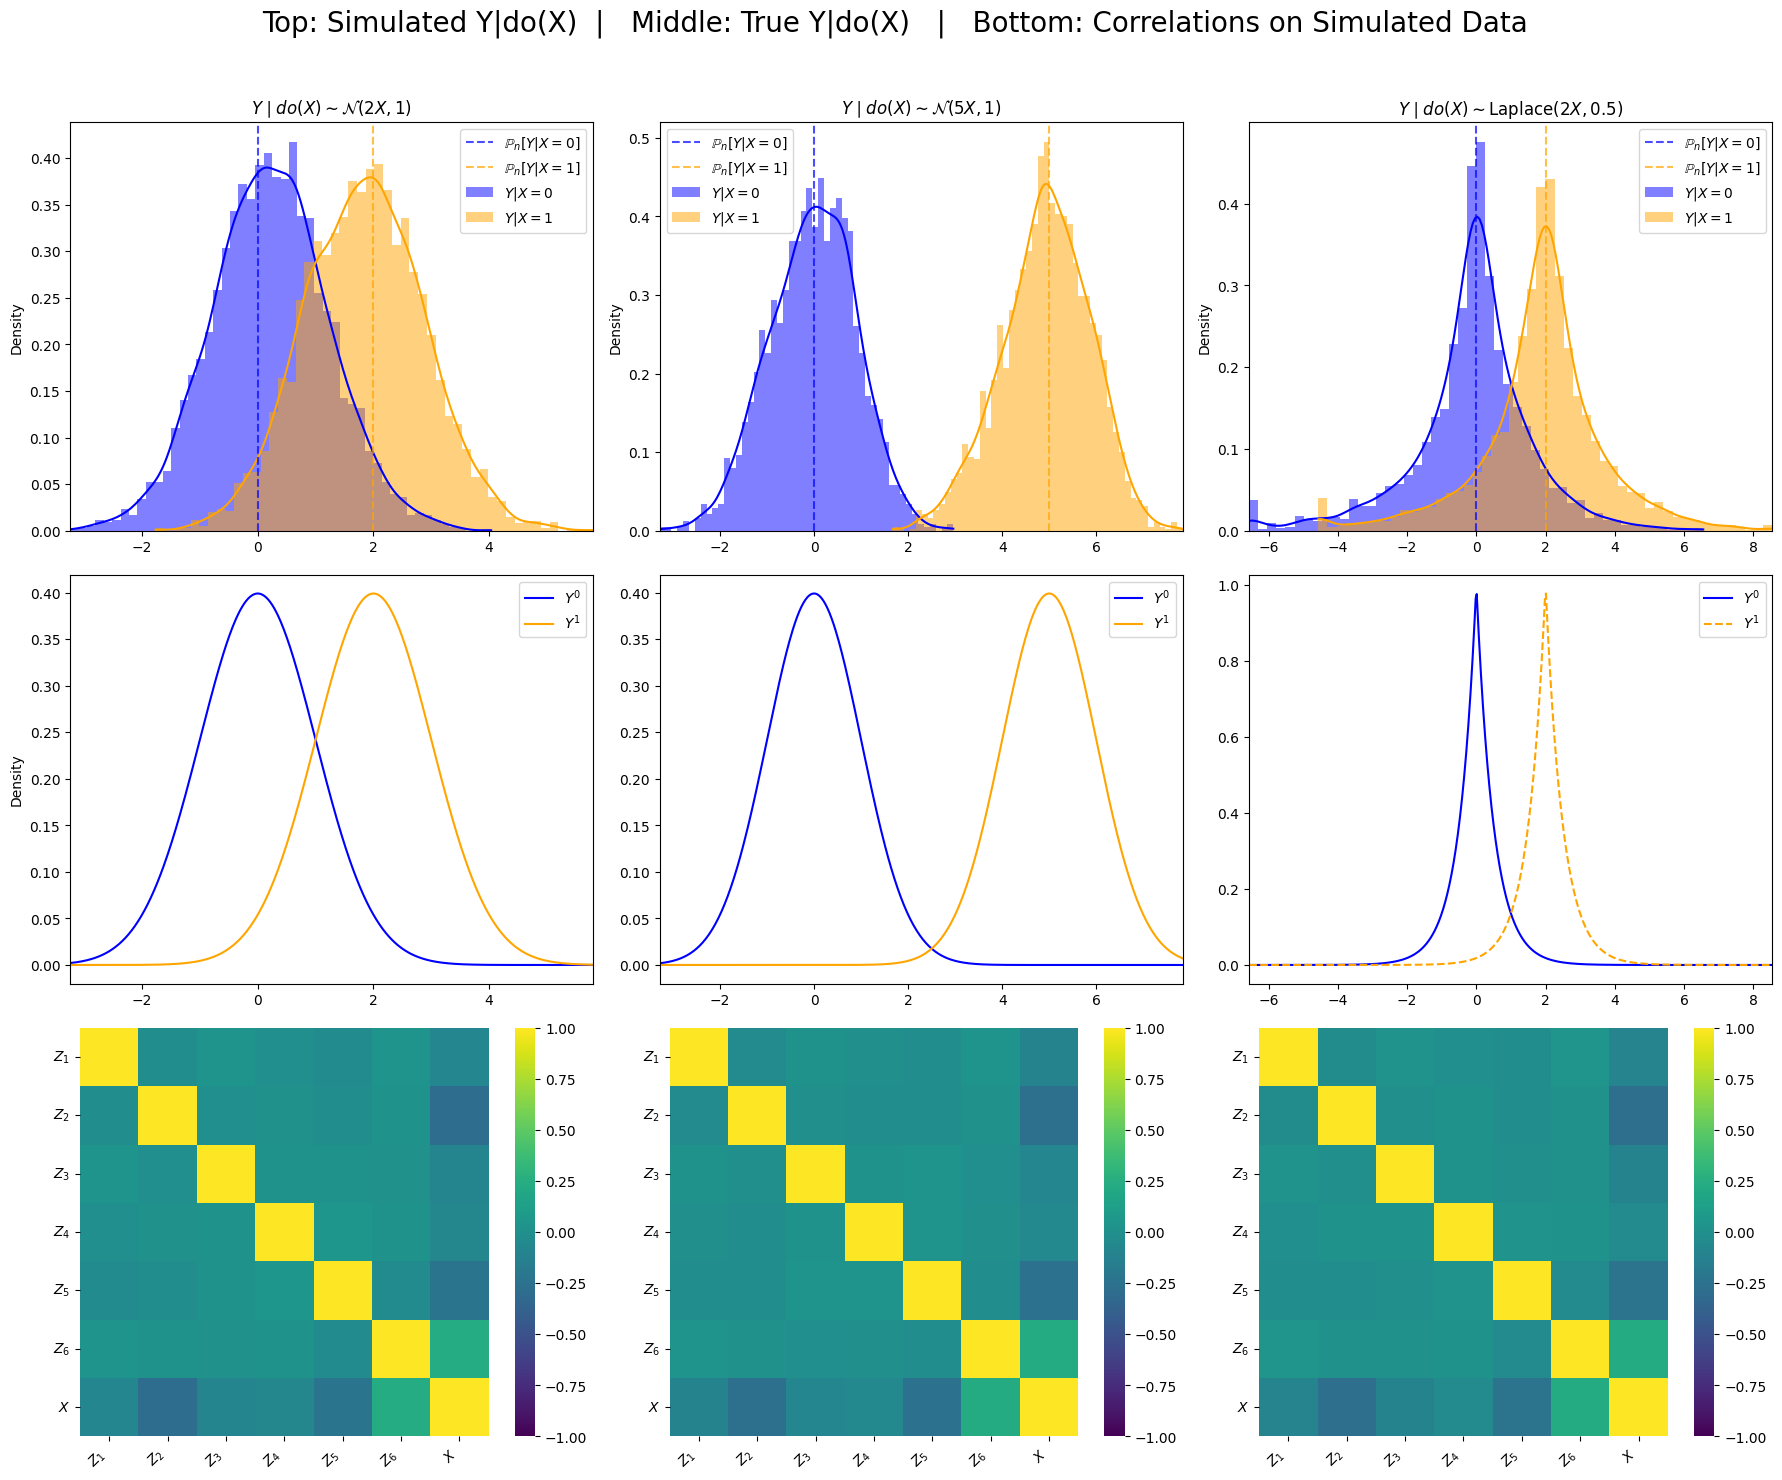

In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, laplace

# — your data arrays must already be defined — 
# x0_samples, x1_samples               
# sampled_x_5x, sampled_y_5x           
# sampled_x_0x, sampled_y_0x           
# z0_samples, z1_samples               # shape (n_obs, p)
# sampled_z_5x, sampled_z_0x           # shape (n_obs, p)
# sampled_z, sampled_x                 # combined marginals for col-0

fig, axes = plt.subplots(3, 3, figsize=(18, 15), sharey=False)

# # 1) Rotated row titles
# row_labels = [
#     "marginal distribution – simulation",
#     "marginal distribution – ground truth",
#     "correlation – simulated data"
# ]
# y_positions = [0.82, 0.50, 0.18]
# for lab, y in zip(row_labels, y_positions):
#     fig.text(
#         x=0.0, y=y, s=lab,
#         va='center', ha='center',
#         rotation=90, fontsize=16, weight='bold'
#     )

# 2) Compute per-column x-limits
y0 = np.concatenate([np.ravel(x0_samples), np.ravel(x1_samples)])
xmin0, xmax0 = y0.min(), y0.max()
y1 = np.ravel(sampled_y_5x); xmin1, xmax1 = y1.min(), y1.max()
y2 = np.ravel(sampled_y_2x); xmin2, xmax2 = y2.min(), y2.max()

# Common histogram + KDE styling
hist_args = dict(
    stat="density",
    bins=50,
    kde=True,           # fit & plot KDE
    edgecolor=None,
    alpha=0.5
)

### Row 1: simulated marginals ###
# Col 0
sns.histplot(x0_samples, color='blue', label='$Y|X=0$', ax=axes[0,0], **hist_args)
sns.histplot(x1_samples, color='orange', label='$Y|X=1$', ax=axes[0,0], **hist_args)
axes[0,0].axvline(0, linestyle='--', color='blue',
                  label=r'$\mathbb{P}_n[Y|X=0]$', alpha=0.7)
axes[0,0].axvline(2, linestyle='--', color='orange',
                  label=r'$\mathbb{P}_n[Y|X=1]$', alpha=0.7)
axes[0,0].set_title(r"$Y\mid do(X)\sim\mathcal{N}(2X,1)$")
axes[0,0].set_xlim(xmin0, xmax0)
axes[0,0].legend()
axes[0,0].set_ylabel("Density")

# Col 1
sns.histplot(sampled_y_5x[sampled_x_5x==0], color='blue',
             label='$Y|X=0$', ax=axes[0,1], **hist_args)
sns.histplot(sampled_y_5x[sampled_x_5x==1], color='orange',
             label='$Y|X=1$', ax=axes[0,1], **hist_args)
axes[0,1].axvline(0, linestyle='--', color='blue',
                  label=r'$\mathbb{P}_n[Y|X=0]$', alpha=0.7)
axes[0,1].axvline(5, linestyle='--', color='orange',
                  label=r'$\mathbb{P}_n[Y|X=1]$', alpha=0.7)
axes[0,1].set_title(r"$Y\mid do(X)\sim\mathcal{N}(5X,1)$")
axes[0,1].set_xlim(xmin1, xmax1)
axes[0,1].legend()

# Col 2
sns.histplot(sampled_y_2x[sampled_x_2x==0], color='blue',
             label='$Y|X=0$', ax=axes[0,2], **hist_args)
sns.histplot(sampled_y_2x[sampled_x_2x==1], color='orange',
             label='$Y|X=1$', ax=axes[0,2], **hist_args)
axes[0,2].axvline(0, linestyle='--', color='blue',
                  label=r'$\mathbb{P}_n[Y|X=0]$', alpha=0.7)
axes[0,2].axvline(2, linestyle='--', color='orange',
                label=r'$\mathbb{P}_n[Y|X=1]$', alpha=0.7)
axes[0,2].set_title(r"$Y\mid do(X)\sim \operatorname{Laplace}(2X,0.5)$")
axes[0,2].set_xlim(xmin2, xmax2)
axes[0,2].legend()



### Row 2: ground-truth marginals ###
ygrid0 = np.linspace(xmin0, xmax0, 500)
ygrid1 = np.linspace(xmin1, xmax1, 500)
ygrid2 = np.linspace(xmin2, xmax2, 500)

# Col 0
axes[1,0].plot(ygrid0, norm.pdf(ygrid0, loc=0, scale=1),
               label='$Y^0$', color='blue')
axes[1,0].plot(ygrid0, norm.pdf(ygrid0, loc=2, scale=1),
               label='$Y^1$', color='orange')
axes[1,0].set_xlim(xmin0, xmax0)
axes[1,0].legend()
axes[1,0].set_ylabel("Density")

# Col 1
axes[1,1].plot(ygrid1, norm.pdf(ygrid1, loc=0, scale=1),
               label='$Y^0$', color='blue')
axes[1,1].plot(ygrid1, norm.pdf(ygrid1, loc=5, scale=1),
               label='$Y^1$', color='orange')
axes[1,1].set_xlim(xmin1, xmax1)
axes[1,1].legend()

# Col 2
axes[1,2].plot(ygrid2, laplace.pdf(ygrid2, loc=0, scale=0.5),
               label='$Y^0$', color='blue')
axes[1,2].plot(ygrid2, laplace.pdf(ygrid2, loc=2, scale=0.5),
               label='$Y^1$', color='orange', linestyle='--')
axes[1,2].set_xlim(xmin2, xmax2)
axes[1,2].legend()


### Row 3: correlation heatmaps of (Z₁,…,Zₚ, X) ###
def corr_heatmap(z, x, ax):
    z_arr = np.asarray(z)
    x_arr = np.asarray(x).ravel()
    n, p = z_arr.shape
    df = pd.DataFrame(z_arr, columns=[f'Z_{i+1}' for i in range(p)])
    df['X'] = x_arr
    corr = df.corr()
    sns.heatmap(
        corr, annot=False,
        cmap='viridis', vmin=-1, vmax=1,
        square=True, ax=ax
    )
    labels = [rf'$Z_{{{i+1}}}$' for i in range(p)] + ['$X$']
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_yticklabels(labels, rotation=0)


# Col 0: combined marginals
corr_heatmap(sampled_z, sampled_x, axes[2,0])

# Col 1: joint ATE=5
corr_heatmap(sampled_z_5x, sampled_x_5x, axes[2,1])

# Col 2: joint ATE=0
corr_heatmap(sampled_z_2x, sampled_x_2x, axes[2,2])

# Final layout
plt.suptitle(
    "Top: Simulated Y|do(X)  |   Middle: True Y|do(X)   |   Bottom: Correlations on Simulated Data",
    fontsize=20, y=0.98
)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


# With confounding variable

In [2]:
np.random.seed(42)
n_tr = 5000  # Training sample size

nI = 2# Fixed number of instrumental variables
nX = 2
nO = 2
nS = 0
binary_intervention = True
# num_iters = 1500 # Fixed number of training iterations
ate = 4
strength_conf = 2
strength_outcome = 2
strength_insr=2
beta_cov = 0
strength_instr = 0

In [3]:
df_tr = generate_data_causl(n=5000, nI =nI, nX= nX, nO = nO, nS = nS, ate = ate, beta_cov = beta_cov, strength_instr = strength_instr, strength_conf = strength_conf, strength_outcome =strength_outcome, binary_intervention=binary_intervention)
z_tr = torch.tensor(df_tr[[f"X{i}" for i in range(1, p + 1)]].values, dtype=torch.float32)
x_tr = torch.tensor(df_tr['A'].values, dtype=torch.int32).view(-1, 1)
y_tr = torch.tensor(df_tr['y'].values, dtype=torch.float32).view(-1, 1)

In [4]:

model = Frengression(x_tr.shape[1], y_tr.shape[1], z_tr.shape[1], noise_dim=1, num_layer=3, hidden_dim=100, device=device, x_binary = binary_intervention)
model.train_xz(x_tr, z_tr, num_iters=5000, lr=1e-4, print_every_iter=1000)
model.train_y(x_tr, z_tr, y_tr, num_iters=5000, lr=1e-4, print_every_iter=200,tol=0.001)

Epoch 1: loss 2.2855, loss1 2.4087, loss2 0.2463
Epoch 1000: loss 1.7044, loss1 3.3608, loss2 3.3128
Epoch 2000: loss 1.6896, loss1 3.3575, loss2 3.3357
Epoch 3000: loss 1.6929, loss1 3.3612, loss2 3.3366
Epoch 4000: loss 1.6899, loss1 3.3705, loss2 3.3612
Epoch 5000: loss 1.7020, loss1 3.3660, loss2 3.3281
Epoch 1: loss 3.2555,	loss_y 2.4888, 2.5058, 0.0341,	loss_eta 0.7667, 0.7987, 0.0639
Epoch 200: loss 1.7051,	loss_y 1.0992, 1.4732, 0.7481,	loss_eta 0.6059, 1.2681, 1.3244
Epoch 400: loss 0.6782,	loss_y 0.1188, 0.2437, 0.2498,	loss_eta 0.5594, 1.1347, 1.1506
Stopping at iter 403: |Δy|=-3.8470e-04, |Δη|=-1.1599e-04


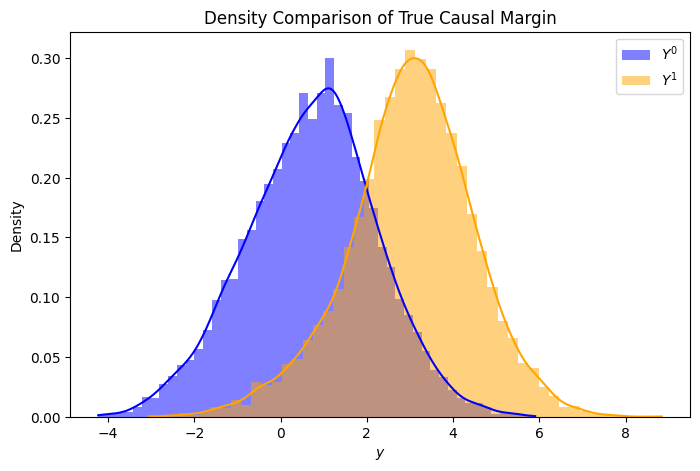

In [5]:
# Sample causal margins
x0_samples = model.sample_causal_margin(x=torch.tensor([[0]], dtype=torch.int32), sample_size=10000).numpy().flatten()
x1_samples = model.sample_causal_margin(x=torch.tensor([[1]], dtype=torch.int32), sample_size=10000).numpy().flatten()

# Plot histograms and KDE
plt.figure(figsize=(8, 5))

# Histogram for x0_samples
sns.histplot(x0_samples, kde=True, color='blue', label='$Y^0$', stat="density", bins=50, edgecolor=None, alpha=0.5)

# Histogram for x1_samples
sns.histplot(x1_samples, kde=True, color='orange', label='$Y^1$', stat="density", bins=50, edgecolor=None, alpha=0.5)

# Highlight different supports (if needed)
# plt.axvline(min(x0_samples), color='blue', linestyle='--', alpha=0.7, label='$Y^0$ suppor end')
# plt.axvline(max(x0_samples), color='blue', linestyle='--', alpha=0.7)
# plt.axvline(min(x1_samples), color='orange', linestyle='--', alpha=0.7, label='$Y^1$ support end')
# plt.axvline(max(x1_samples), color='orange', linestyle='--', alpha=0.7)

# Add labels, legend, and title
plt.xlabel("$y$")
plt.ylabel("Density")
plt.title("Density Comparison of True Causal Margin")
plt.legend()
plt.show()


In [6]:
model.train_y(x_tr, z_tr, y_tr, num_iters=2000, lr=1e-4, print_every_iter=200,tol=0)

Epoch 1: loss 0.6824,	loss_y 0.1173, 0.2393, 0.2442,	loss_eta 0.5652, 1.1280, 1.1258
Epoch 200: loss 0.6717,	loss_y 0.1036, 0.2078, 0.2084,	loss_eta 0.5681, 1.1131, 1.0899
Epoch 400: loss 0.6726,	loss_y 0.0994, 0.2036, 0.2083,	loss_eta 0.5732, 1.1251, 1.1038
Epoch 600: loss 0.6478,	loss_y 0.1006, 0.2012, 0.2013,	loss_eta 0.5472, 1.0957, 1.0969
Epoch 800: loss 0.6756,	loss_y 0.1011, 0.1984, 0.1945,	loss_eta 0.5745, 1.1188, 1.0886
Epoch 1000: loss 0.6567,	loss_y 0.0991, 0.1965, 0.1947,	loss_eta 0.5576, 1.1009, 1.0867
Epoch 1200: loss 0.6437,	loss_y 0.0994, 0.1970, 0.1952,	loss_eta 0.5442, 1.1003, 1.1120
Epoch 1400: loss 0.6419,	loss_y 0.0984, 0.1960, 0.1951,	loss_eta 0.5434, 1.0981, 1.1092
Epoch 1600: loss 0.6750,	loss_y 0.0968, 0.1973, 0.2009,	loss_eta 0.5782, 1.1267, 1.0970
Epoch 1800: loss 0.6583,	loss_y 0.0945, 0.1943, 0.1996,	loss_eta 0.5638, 1.1174, 1.1073
Epoch 2000: loss 0.6658,	loss_y 0.0980, 0.1914, 0.1869,	loss_eta 0.5679, 1.1227, 1.1096


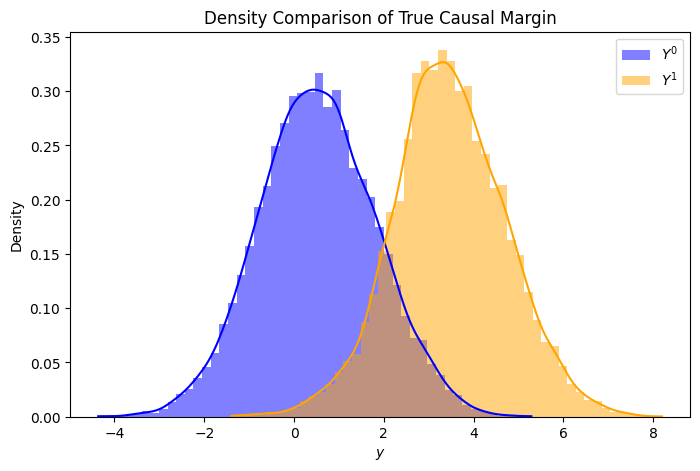

In [7]:
# Sample causal margins
x0_samples = model.sample_causal_margin(x=torch.tensor([[0]], dtype=torch.int32), sample_size=10000).numpy().flatten()
x1_samples = model.sample_causal_margin(x=torch.tensor([[1]], dtype=torch.int32), sample_size=10000).numpy().flatten()

# Plot histograms and KDE
plt.figure(figsize=(8, 5))

# Histogram for x0_samples
sns.histplot(x0_samples, kde=True, color='blue', label='$Y^0$', stat="density", bins=50, edgecolor=None, alpha=0.5)

# Histogram for x1_samples
sns.histplot(x1_samples, kde=True, color='orange', label='$Y^1$', stat="density", bins=50, edgecolor=None, alpha=0.5)

# Highlight different supports (if needed)
# plt.axvline(min(x0_samples), color='blue', linestyle='--', alpha=0.7, label='$Y^0$ suppor end')
# plt.axvline(max(x0_samples), color='blue', linestyle='--', alpha=0.7)
# plt.axvline(min(x1_samples), color='orange', linestyle='--', alpha=0.7, label='$Y^1$ support end')
# plt.axvline(max(x1_samples), color='orange', linestyle='--', alpha=0.7)

# Add labels, legend, and title
plt.xlabel("$y$")
plt.ylabel("Density")
plt.title("Density Comparison of True Causal Margin")
plt.legend()
plt.show()


In [8]:
model.train_y(x_tr, z_tr, y_tr, num_iters=2000, lr=1e-4, print_every_iter=200,tol=0)

Epoch 1: loss 0.6466,	loss_y 0.0971, 0.1931, 0.1919,	loss_eta 0.5494, 1.0986, 1.0984
Epoch 200: loss 0.6649,	loss_y 0.0971, 0.1947, 0.1951,	loss_eta 0.5677, 1.1197, 1.1038
Epoch 400: loss 0.6484,	loss_y 0.0936, 0.1917, 0.1961,	loss_eta 0.5548, 1.1127, 1.1158
Epoch 600: loss 0.6756,	loss_y 0.0954, 0.1909, 0.1910,	loss_eta 0.5802, 1.1242, 1.0880
Epoch 800: loss 0.6597,	loss_y 0.0941, 0.1866, 0.1849,	loss_eta 0.5656, 1.1127, 1.0943
Epoch 1000: loss 0.6790,	loss_y 0.0937, 0.1893, 0.1912,	loss_eta 0.5853, 1.1239, 1.0772
Epoch 1200: loss 0.6560,	loss_y 0.0942, 0.1865, 0.1847,	loss_eta 0.5618, 1.1072, 1.0908
Epoch 1400: loss 0.6701,	loss_y 0.0944, 0.1865, 0.1841,	loss_eta 0.5757, 1.1256, 1.0998
Epoch 1600: loss 0.6698,	loss_y 0.0933, 0.1864, 0.1862,	loss_eta 0.5765, 1.1216, 1.0901
Epoch 1800: loss 0.6586,	loss_y 0.0919, 0.1843, 0.1849,	loss_eta 0.5667, 1.1143, 1.0952
Epoch 2000: loss 0.6672,	loss_y 0.0923, 0.1834, 0.1823,	loss_eta 0.5749, 1.1223, 1.0947


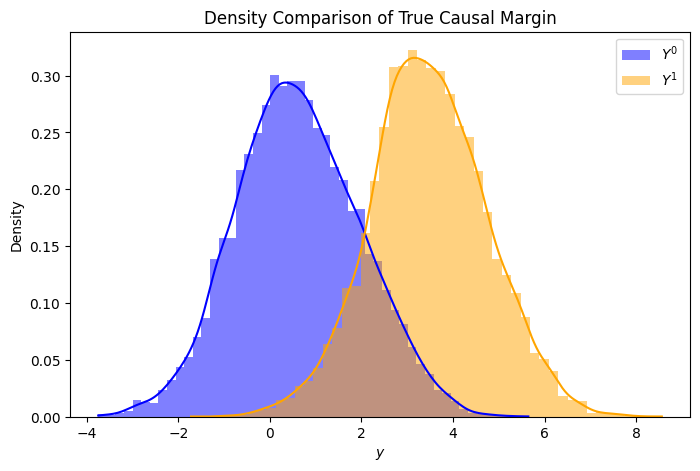

In [9]:
# Sample causal margins
x0_samples = model.sample_causal_margin(x=torch.tensor([[0]], dtype=torch.int32), sample_size=10000).numpy().flatten()
x1_samples = model.sample_causal_margin(x=torch.tensor([[1]], dtype=torch.int32), sample_size=10000).numpy().flatten()

# Plot histograms and KDE
plt.figure(figsize=(8, 5))

# Histogram for x0_samples
sns.histplot(x0_samples, kde=True, color='blue', label='$Y^0$', stat="density", bins=50, edgecolor=None, alpha=0.5)

# Histogram for x1_samples
sns.histplot(x1_samples, kde=True, color='orange', label='$Y^1$', stat="density", bins=50, edgecolor=None, alpha=0.5)

# Highlight different supports (if needed)
# plt.axvline(min(x0_samples), color='blue', linestyle='--', alpha=0.7, label='$Y^0$ suppor end')
# plt.axvline(max(x0_samples), color='blue', linestyle='--', alpha=0.7)
# plt.axvline(min(x1_samples), color='orange', linestyle='--', alpha=0.7, label='$Y^1$ support end')
# plt.axvline(max(x1_samples), color='orange', linestyle='--', alpha=0.7)

# Add labels, legend, and title
plt.xlabel("$y$")
plt.ylabel("Density")
plt.title("Density Comparison of True Causal Margin")
plt.legend()
plt.show()


Epoch 1: loss 0.6624,	loss_y 0.0913, 0.1825, 0.1824,	loss_eta 0.5711, 1.1168, 1.0913
Epoch 200: loss 0.6609,	loss_y 0.0921, 0.1838, 0.1835,	loss_eta 0.5688, 1.1194, 1.1012
Epoch 400: loss 0.6761,	loss_y 0.0922, 0.1836, 0.1828,	loss_eta 0.5839, 1.1287, 1.0896
Epoch 600: loss 0.6669,	loss_y 0.0909, 0.1820, 0.1822,	loss_eta 0.5760, 1.1220, 1.0920
Epoch 800: loss 0.6466,	loss_y 0.0926, 0.1841, 0.1830,	loss_eta 0.5540, 1.1158, 1.1238
Epoch 1000: loss 0.6354,	loss_y 0.0900, 0.1795, 0.1789,	loss_eta 0.5454, 1.1015, 1.1122
Epoch 1200: loss 0.6570,	loss_y 0.0918, 0.1828, 0.1819,	loss_eta 0.5653, 1.1116, 1.0927
Epoch 1400: loss 0.6599,	loss_y 0.0917, 0.1803, 0.1772,	loss_eta 0.5683, 1.1082, 1.0798
Epoch 1600: loss 0.6474,	loss_y 0.0884, 0.1785, 0.1803,	loss_eta 0.5590, 1.1092, 1.1004
Epoch 1800: loss 0.6474,	loss_y 0.0922, 0.1811, 0.1778,	loss_eta 0.5552, 1.1063, 1.1021
Epoch 2000: loss 0.6649,	loss_y 0.0890, 0.1758, 0.1736,	loss_eta 0.5759, 1.1261, 1.1005


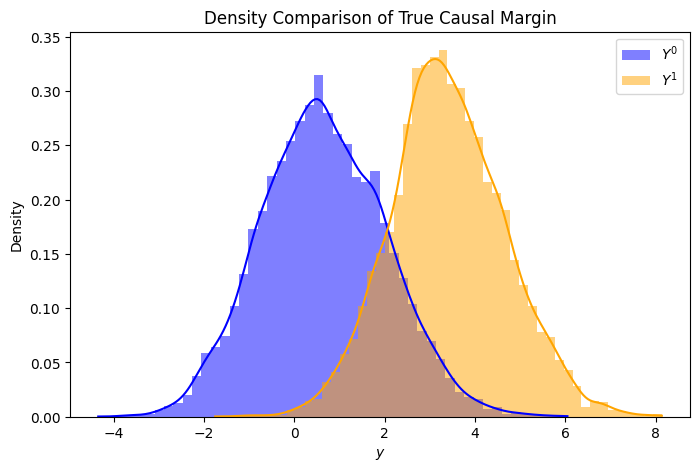

In [10]:
model.train_y(x_tr, z_tr, y_tr, num_iters=2000, lr=1e-4, print_every_iter=200,tol=0)
# Sample causal margins
x0_samples = model.sample_causal_margin(x=torch.tensor([[0]], dtype=torch.int32), sample_size=10000).numpy().flatten()
x1_samples = model.sample_causal_margin(x=torch.tensor([[1]], dtype=torch.int32), sample_size=10000).numpy().flatten()

# Plot histograms and KDE
plt.figure(figsize=(8, 5))

# Histogram for x0_samples
sns.histplot(x0_samples, kde=True, color='blue', label='$Y^0$', stat="density", bins=50, edgecolor=None, alpha=0.5)

# Histogram for x1_samples
sns.histplot(x1_samples, kde=True, color='orange', label='$Y^1$', stat="density", bins=50, edgecolor=None, alpha=0.5)

# Highlight different supports (if needed)
# plt.axvline(min(x0_samples), color='blue', linestyle='--', alpha=0.7, label='$Y^0$ suppor end')
# plt.axvline(max(x0_samples), color='blue', linestyle='--', alpha=0.7)
# plt.axvline(min(x1_samples), color='orange', linestyle='--', alpha=0.7, label='$Y^1$ support end')
# plt.axvline(max(x1_samples), color='orange', linestyle='--', alpha=0.7)

# Add labels, legend, and title
plt.xlabel("$y$")
plt.ylabel("Density")
plt.title("Density Comparison of True Causal Margin")
plt.legend()
plt.show()


Epoch 1: loss 0.6674,	loss_y 0.0879, 0.1775, 0.1790,	loss_eta 0.5795, 1.1200, 1.0812
Epoch 200: loss 0.6547,	loss_y 0.0884, 0.1784, 0.1801,	loss_eta 0.5664, 1.1094, 1.0861
Epoch 400: loss 0.6515,	loss_y 0.0919, 0.1784, 0.1730,	loss_eta 0.5596, 1.1054, 1.0916
Epoch 600: loss 0.6522,	loss_y 0.0888, 0.1747, 0.1718,	loss_eta 0.5634, 1.1057, 1.0845
Epoch 800: loss 0.6662,	loss_y 0.0887, 0.1791, 0.1807,	loss_eta 0.5775, 1.1251, 1.0952
Epoch 1000: loss 0.6510,	loss_y 0.0879, 0.1756, 0.1755,	loss_eta 0.5631, 1.1097, 1.0932
Epoch 1200: loss 0.6515,	loss_y 0.0877, 0.1744, 0.1734,	loss_eta 0.5638, 1.1028, 1.0779
Epoch 1400: loss 0.6570,	loss_y 0.0883, 0.1731, 0.1695,	loss_eta 0.5687, 1.1111, 1.0849
Epoch 1600: loss 0.6563,	loss_y 0.0874, 0.1743, 0.1739,	loss_eta 0.5689, 1.1142, 1.0906
Epoch 1800: loss 0.6582,	loss_y 0.0861, 0.1728, 0.1734,	loss_eta 0.5721, 1.1145, 1.0848
Epoch 2000: loss 0.6680,	loss_y 0.0882, 0.1761, 0.1760,	loss_eta 0.5798, 1.1220, 1.0844
Epoch 2200: loss 0.6578,	loss_y 0.0852,

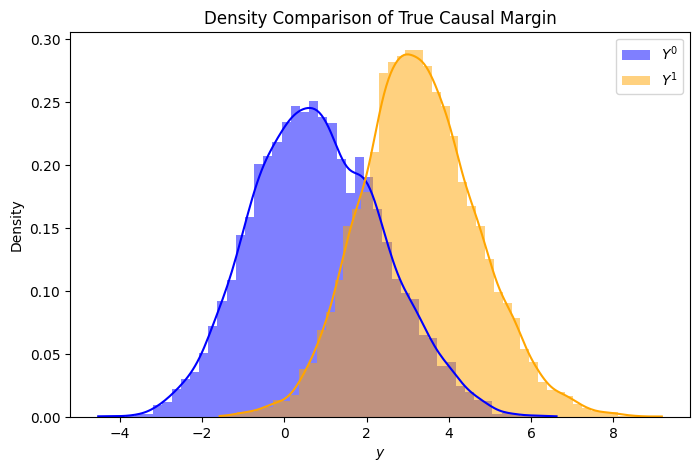

In [11]:
model.train_y(x_tr, z_tr, y_tr, num_iters=5000, lr=1e-4, print_every_iter=200,tol=0)
# Sample causal margins
x0_samples = model.sample_causal_margin(x=torch.tensor([[0]], dtype=torch.int32), sample_size=10000).numpy().flatten()
x1_samples = model.sample_causal_margin(x=torch.tensor([[1]], dtype=torch.int32), sample_size=10000).numpy().flatten()

# Plot histograms and KDE
plt.figure(figsize=(8, 5))

# Histogram for x0_samples
sns.histplot(x0_samples, kde=True, color='blue', label='$Y^0$', stat="density", bins=50, edgecolor=None, alpha=0.5)

# Histogram for x1_samples
sns.histplot(x1_samples, kde=True, color='orange', label='$Y^1$', stat="density", bins=50, edgecolor=None, alpha=0.5)

# Highlight different supports (if needed)
# plt.axvline(min(x0_samples), color='blue', linestyle='--', alpha=0.7, label='$Y^0$ suppor end')
# plt.axvline(max(x0_samples), color='blue', linestyle='--', alpha=0.7)
# plt.axvline(min(x1_samples), color='orange', linestyle='--', alpha=0.7, label='$Y^1$ support end')
# plt.axvline(max(x1_samples), color='orange', linestyle='--', alpha=0.7)

# Add labels, legend, and title
plt.xlabel("$y$")
plt.ylabel("Density")
plt.title("Density Comparison of True Causal Margin")
plt.legend()
plt.show()


Epoch 1: loss 0.6493,	loss_y 0.0827, 0.1668, 0.1682,	loss_eta 0.5665, 1.1015, 1.0700
Epoch 200: loss 0.6366,	loss_y 0.0818, 0.1636, 0.1637,	loss_eta 0.5548, 1.0909, 1.0722
Epoch 400: loss 0.6526,	loss_y 0.0833, 0.1643, 0.1620,	loss_eta 0.5692, 1.1106, 1.0828
Epoch 600: loss 0.6544,	loss_y 0.0826, 0.1607, 0.1561,	loss_eta 0.5717, 1.1131, 1.0828
Epoch 800: loss 0.6493,	loss_y 0.0800, 0.1616, 0.1632,	loss_eta 0.5692, 1.1052, 1.0719
Epoch 1000: loss 0.6501,	loss_y 0.0802, 0.1635, 0.1665,	loss_eta 0.5698, 1.1069, 1.0742
Epoch 1200: loss 0.6563,	loss_y 0.0797, 0.1629, 0.1665,	loss_eta 0.5767, 1.1116, 1.0700
Epoch 1400: loss 0.6362,	loss_y 0.0814, 0.1604, 0.1580,	loss_eta 0.5548, 1.0977, 1.0857
Epoch 1600: loss 0.6576,	loss_y 0.0820, 0.1650, 0.1660,	loss_eta 0.5756, 1.1037, 1.0562
Epoch 1800: loss 0.6545,	loss_y 0.0804, 0.1602, 0.1597,	loss_eta 0.5742, 1.1064, 1.0645
Epoch 2000: loss 0.6340,	loss_y 0.0803, 0.1614, 0.1623,	loss_eta 0.5537, 1.0927, 1.0781
Epoch 2200: loss 0.6444,	loss_y 0.0796,

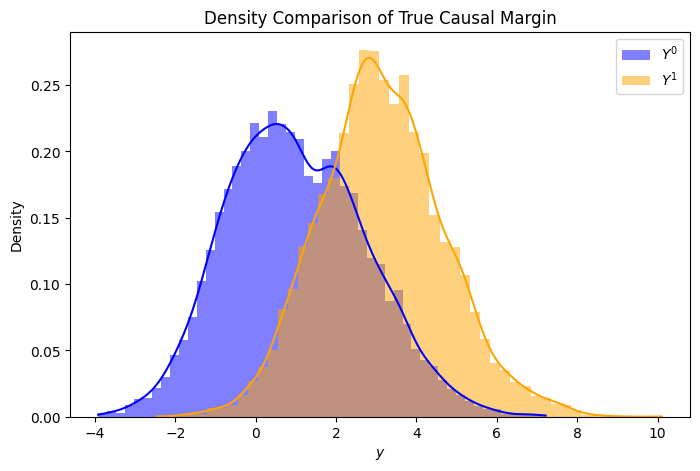

In [12]:
model.train_y(x_tr, z_tr, y_tr, num_iters=8000, lr=1e-4, print_every_iter=200,tol=0)
# Sample causal margins
x0_samples = model.sample_causal_margin(x=torch.tensor([[0]], dtype=torch.int32), sample_size=10000).numpy().flatten()
x1_samples = model.sample_causal_margin(x=torch.tensor([[1]], dtype=torch.int32), sample_size=10000).numpy().flatten()

# Plot histograms and KDE
plt.figure(figsize=(8, 5))

# Histogram for x0_samples
sns.histplot(x0_samples, kde=True, color='blue', label='$Y^0$', stat="density", bins=50, edgecolor=None, alpha=0.5)

# Histogram for x1_samples
sns.histplot(x1_samples, kde=True, color='orange', label='$Y^1$', stat="density", bins=50, edgecolor=None, alpha=0.5)

# Highlight different supports (if needed)
# plt.axvline(min(x0_samples), color='blue', linestyle='--', alpha=0.7, label='$Y^0$ suppor end')
# plt.axvline(max(x0_samples), color='blue', linestyle='--', alpha=0.7)
# plt.axvline(min(x1_samples), color='orange', linestyle='--', alpha=0.7, label='$Y^1$ support end')
# plt.axvline(max(x1_samples), color='orange', linestyle='--', alpha=0.7)

# Add labels, legend, and title
plt.xlabel("$y$")
plt.ylabel("Density")
plt.title("Density Comparison of True Causal Margin")
plt.legend()
plt.show()
